# Social network Graph Link Prediction - Facebook Challenge

# 1. Problem statement

Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

# 2. Data Overview

Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph

    - Data columns (total 2 columns):  
       * source_node         int64  
       * destination_node    int64  

## 2.1 Mapping the problem into supervised learning problem

- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

## 2.2 Business objectives and constraints

- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

## 2.3 Performance metric for supervised learning:  

- Both precision and recall is important so F1 score is good choice
- Confusion matrix

## 2.4 Reading the data

In [0]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")
import math, pickle, os, pdb, csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from matplotlib_venn import venn2, venn3
import networkx as nx
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import datetime #Convert to unix time
import time #Convert to unix time
from sklearn.model_selection import train_test_split

In [0]:
d = '/content/drive/My Drive/Colab Notebooks/Datasets/Case_Study/Facebook friend recommendation/'

In [4]:
df = pd.read_csv(d+'train.csv')
print('Shape: {}\nNumber of NaN: {}\nNumber of duplicates: {}\n'.format(df.shape, df.isnull().values.sum(), sum(df.duplicated())))
print(df.info())

if not os.path.isfile(d+'after_eda/train_woheader.csv'):
    df.to_csv(d+'after_eda/train_woheader.csv',header=False,index=False)
    print("\nSaved the data into file without header and index")
else:
    g=nx.read_edgelist(d+'after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    
df.head()

Shape: (9437519, 2)
Number of NaN: 0
Number of duplicates: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 144.0 MB
None


,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [5]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


> Displaying a sub graph

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


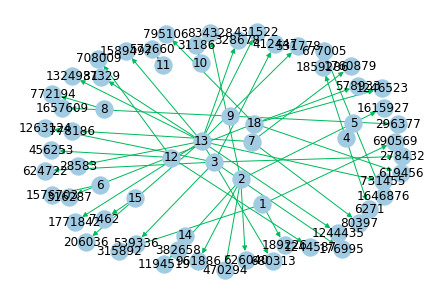

In [6]:
if not os.path.isfile(d+'after_eda/train_woheader_sample.csv'):
    pd.read_csv(d+'train.csv', nrows=50).to_csv(d+'after_eda/train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist(d+'after_eda/train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(subgraph))

# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib
pos=nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color = '#A0CBE2', edge_color = '#00bb5e', width = 1, edge_cmap = plt.cm.Blues, with_labels = True)
plt.show()

# 3. Exploratory Data Analysis

In [7]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


In [0]:
def Plot_follwers(in_out_or_both = 'both'):
    """Give input as type of degree: 'in' for in_degree, 'out' for out_degree and 'both' or combined"""
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, figsize = (19,12))
    
    if in_out_or_both == 'in':
        string = 'followers'
        fallowers_list = list(dict(g.in_degree()).values())
    elif in_out_or_both == 'out':
        string = 'following'     
        fallowers_list = list(dict(g.out_degree()).values())
    else:
        string = '(follwers+following)'     
        in_out_or_both = 'both'
        fallowers_list = list(dict(g.degree()).values())
        
    fallowers_list.sort()

    ax1.plot(fallowers_list)
    ax1.set_xlabel('Index No.', fontsize = 12)
    ax1.set_ylabel('Number of {}'.format(string), fontsize = 12)
    ax1.set_title('Number of {} vs index of users'.format(string), fontsize = 14)
    
    ax2.plot(fallowers_list[0:1500000])
    ax2.set_xlabel('Index No.', fontsize = 12)
    ax2.set_ylabel('Number of {}'.format(string), fontsize = 12)
    ax2.set_title('Number of {} vs index of users\n(Zoomed View)'.format(string), fontsize = 14)
    
    sns.kdeplot(fallowers_list, shade=True, label = 'pdf of '+str(in_out_or_both)+' degree', ax = ax3)
    ax3.set_title('PDF of {} of each person'.format(string), fontsize = 14)
    ax3.legend(fontsize = 12)
    
    ax4 = plt.boxplot(fallowers_list)
    plt.title('Box plot of {}'.format(string), fontsize = 14)
    plt.ylabel('Number of users', fontsize = 12)

    return fallowers_list

## 3.1 No of followers for each person

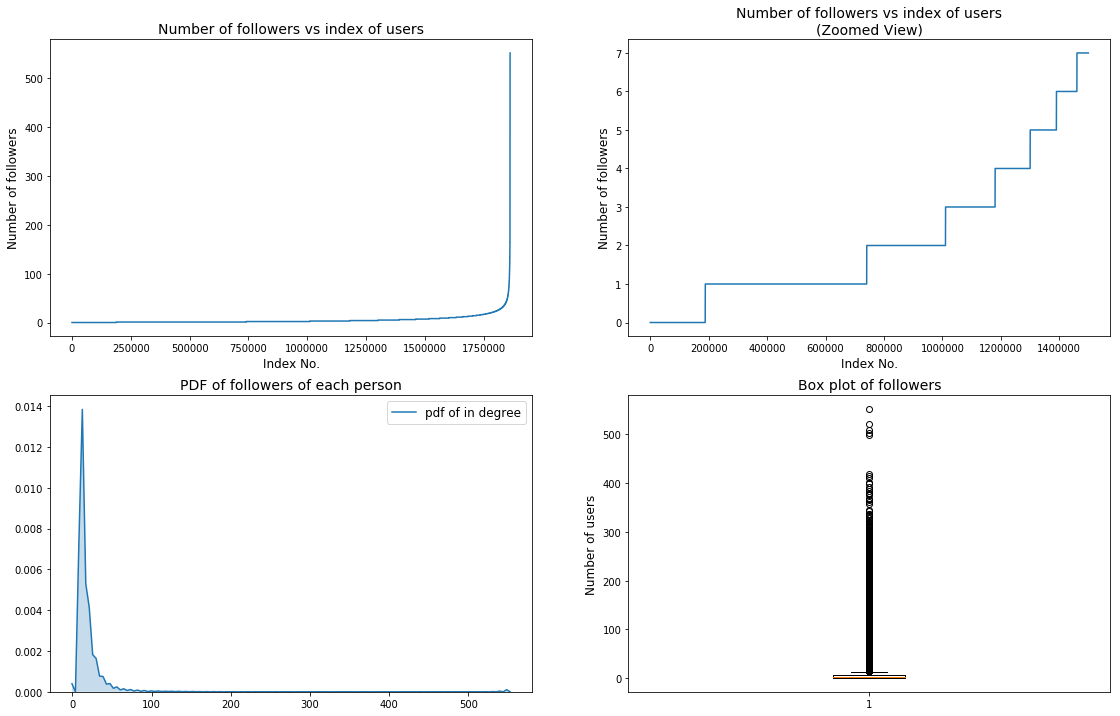

In [9]:
indegree_list = Plot_follwers('in')

* After looking at the __pdf__ plot we can say that distribution of number of followers for users is __highly right skewed__.
* There are very few users who have more than 100 fallowers. Almost 1.4m users have less than 7 fallowers.
* This box plot is not much readable. So let's see the top percentiles.

In [10]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_list,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


99% of data having followers of 40 only.

In [11]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_list,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


In [12]:
print('No of persons having zero followers are' ,sum(np.array(indegree_list)==0),'and % is',
                                sum(np.array(indegree_list)==0)*100/len(indegree_list) )

No of persons having zero followers are 188043 and % is 10.097786512871734


## 1.2 No of people each person is following

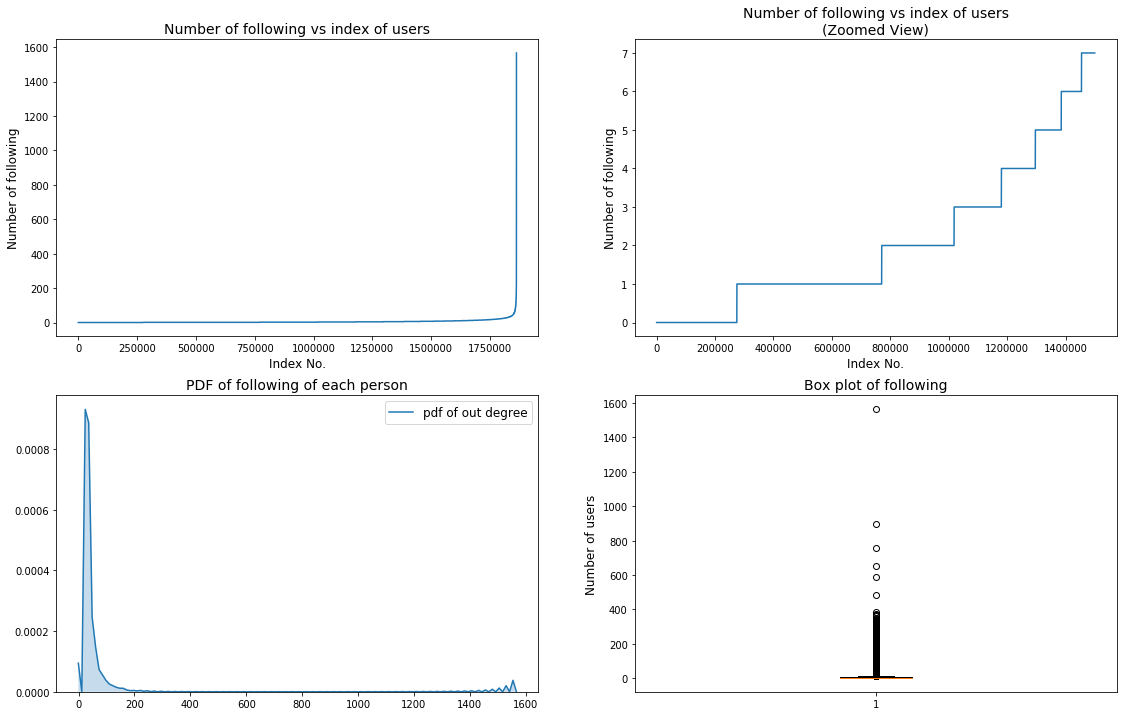

In [13]:
outdegree_list = Plot_follwers('out')

* After looking at the __pdf__ plot we can say that distribution of number of followings for users is __highly right skewed__.
* There are very few users who have more than 100 folliwing. Almost 1.4m users have less than 7 following.
* This box plot is not much readable. So let's see the top percentiles.

In [14]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_list,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


99% of data having followers of 40 only.

In [15]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_list,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


In [16]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_list)==0),'and % is',
                                sum(np.array(outdegree_list)==0)*100/len(outdegree_list) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [17]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


## 1.3 both followers + following 

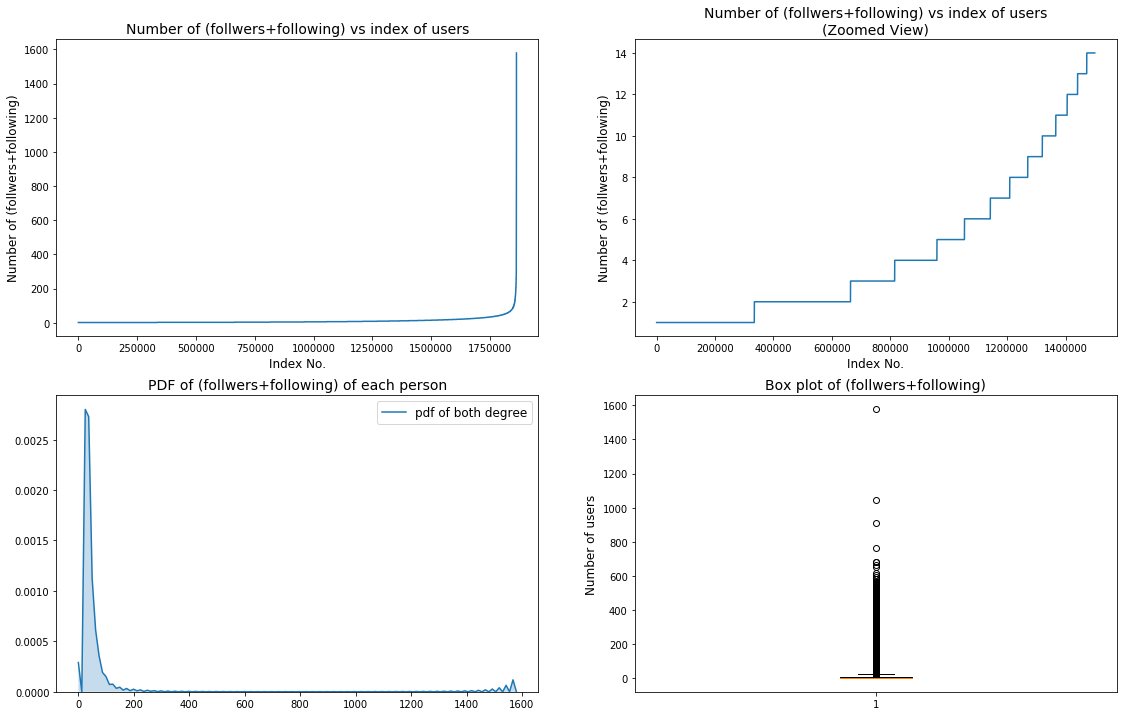

In [18]:
in_out_degree_list = Plot_follwers()

* After looking at the __pdf__ plot we can say that distribution of number of followings + follwers for users is __highly right skewed__.
* There are very few users who have more than 100 (folliwings+follwers). Almost 1.4m users have less than 14 (following+follwers).
* This box plot is not much readable. So let's see the top percentiles.

In [19]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_list,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [20]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_list,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [21]:
in_out_degree_list = np.array(in_out_degree_list)
print('Min of no of followers + following is',in_out_degree_list.min())
print(np.sum(in_out_degree_list==in_out_degree_list.min()),' persons having minimum no of (followers + following)')

Min of no of followers + following is 1
334291  persons having minimum no of (followers + following)


In [22]:
print('Max of no of followers + following is',in_out_degree_list.max())
print(np.sum(in_out_degree_list==in_out_degree_list.max()),' persons having maximum no of (followers + following)')

Max of no of followers + following is 1579
1  persons having maximum no of (followers + following)


In [23]:
print('No of persons having (followers + following) less than 10 are',np.sum(in_out_degree_list<10))

No of persons having (followers + following) less than 10 are 1320326


In [24]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components with 2 nodes',count)

No of weakly connected components 45558
weakly connected components with 2 nodes 32195


# 4. Posing a problem as classification problem 

## 4.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [32]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile(d+'after_eda/missing_edges_final.pkl'):
    #getting all set of edges
    r = csv.reader(open(d+'after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1        
        
    missing_edges = set([])
    
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 
                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open(d+'after_eda/missing_edges_final.pkl','wb'))
else:
    missing_edges = pickle.load(open(d+'after_eda/missing_edges_final.pkl','rb'))

CPU times: user 3.11 s, sys: 832 ms, total: 3.95 s
Wall time: 4.06 s


In [33]:
len(missing_edges)

9437519

## 4.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [34]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile(d+'after_eda/train_pos_after_eda.csv')) and (not os.path.isfile(d+'after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv(d+'train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv(d+'after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv(d+'after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv(d+'after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv(d+'after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


**For Postive Labeled ('1') Data**

In [5]:
if (os.path.isfile(d+'after_eda/train_pos_after_eda.csv')) and (os.path.isfile(d+'after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist(d+'after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist(d+'after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


**For Negative Labeled ('0') Data**

In [6]:
if (os.path.isfile(d+'after_eda/train_neg_after_eda.csv')) and (os.path.isfile(d+'after_eda/test_neg_after_eda.csv')):        
    train_graph=nx.read_edgelist(d+'after_eda/train_neg_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist(d+'after_eda/test_neg_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_neg = set(train_graph.nodes())
    test_nodes_neg = set(test_graph.nodes())

    trY_teY = len(train_nodes_neg.intersection(test_nodes_neg))
    trY_teN = len(train_nodes_neg - test_nodes_neg)
    teY_trN = len(test_nodes_neg - train_nodes_neg)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_neg)*100))

Name: 
Type: DiGraph
Number of nodes: 1861644
Number of edges: 7550015
Average in degree:   4.0556
Average out degree:   4.0556
Name: 
Type: DiGraph
Number of nodes: 1616911
Number of edges: 1887504
Average in degree:   1.1674
Average out degree:   1.1674
no of people common in train and test --  1616410
no of people present in train but not present in test --  245234
no of people present in test but not present in train --  501
 % of people not there in Train but exist in Test in total Test data are 0.030985007832836812 %


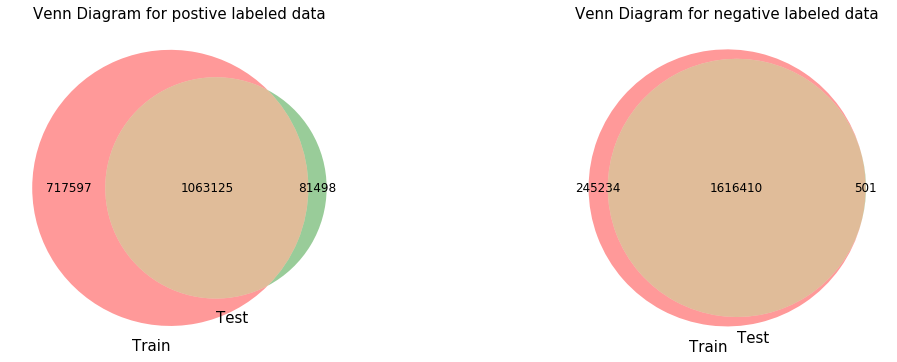

In [12]:
# https://pypi.org/project/matplotlib-venn/
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (18, 6))
out1 = venn2([train_nodes_pos, test_nodes_pos], set_labels = (['Train', 'Test']), ax = ax1)
out2 = venn2([train_nodes_neg, test_nodes_neg], set_labels = (['Train', 'Test']), ax = ax2)
ax1.set_title('Venn Diagram for postively labeled data', fontsize = 15)
ax2.set_title('Venn Diagram for negatively labeled data', fontsize = 15)

# text size of venn diagram: https://stackoverflow.com/a/29426251
for text in out1.set_labels:
    text.set_fontsize(15)
for text in out1.subset_labels:
    text.set_fontsize(12)
    
for text in out2.set_labels:
    text.set_fontsize(15)
for text in out2.subset_labels:
    text.set_fontsize(12)
    
plt.show()

> we have a cold start problem here

In [4]:
#final train and test data sets
if (not os.path.isfile(d+'after_eda/train_after_eda.csv')) and \
(not os.path.isfile(d+'after_eda/test_after_eda.csv')) and \
(not os.path.isfile(d+'train_y.csv')) and \
(not os.path.isfile(d+'test_y.csv')) and \
(os.path.isfile(d+'after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile(d+'after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile(d+'after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile(d+'after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv(d+'after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv(d+'after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv(d+'after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv(d+'after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv(d+'after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv(d+'after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv(d+'after_eda/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv(d+'after_eda/test_y.csv',header=False,index=False)

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


In [5]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)
